# UNet para superresolución de imagenes

**Yamil Ernesto Morfa Avalos**

In [ ]:
#importing the libraries
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

En esta tarea implemente un modelo de Unet para calcular versiones de superresolución de imágenes.


Primero necesitamos establecer la ruta a la carpeta o directorio que contiene los archivos de imagen.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/MyDrive/tarea_6/img'
os.stat(base_dir)

os.stat_result(st_mode=16832, st_ino=68, st_dev=47, st_nlink=2, st_uid=0, st_gid=0, st_size=4096, st_atime=1620366317, st_mtime=1620366314, st_ctime=1620366314)

El directorio contiene 5 imagenes en alta resolución, estas seran redimencionadas a un tamaño de $1000\times800$ pixeles y las guardaremos en un un conjunto que llamaremos imagen_set

In [ ]:
image_set = []
for img in os.listdir(base_dir):
    pic = cv2.imread(os.path.join(base_dir,img))
    pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
    pic = cv2.resize(pic,(800,800))
    image_set.append(pic)

Veamos un ejemplo de dichas imagenes

(800, 800, 3)


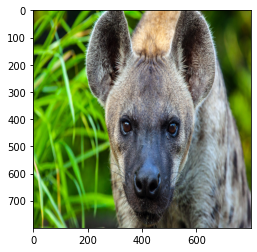

In [ ]:
print(image_set[0].shape)
plt.imshow(image_set[0])
plt.show()


Dado el conjunto de imágenes, se han extraido parches (subimágenes) de $32\times32$ pixeles alazar para conformar el conjunto de entrenamiento (target_set) considerando al menos 10 mil parches. Denotemos a estos parches como:

$$ y = \left[ y_{1}, \, y_{2}, \,...\,,y_{n}\right]$$

In [ ]:
target_set = []
flag = True
while flag:
  for image in image_set:
    i = np.random.randint(800 - 32)
    j = np.random.randint(800 - 32)
    parche = image[i:i+32, j:j+32]
    target_set.append(parche)
  if len(target_set) >= 10000:
    flag = False

In [ ]:
target_set = np.array(target_set)/255

(10000, 32, 32, 3)


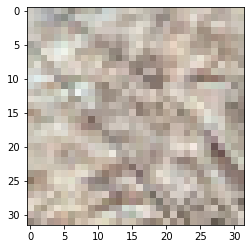

In [ ]:
print(target_set.shape)
plt.imshow(target_set[np.random.randint(10000)])
plt.show()


Reduciremos cada parchet a la mitad de su resolución: $16\times16$ pixeles y denotemos estos como: 
$$ x = \left[ x_{1}, \, x_{2}, \,...\,,x_{n}\right]$$

donde cada $x_{i}$ corresponde al parche $y_{i}$. Guardemos estas en train_set

(10000, 16, 16, 3)


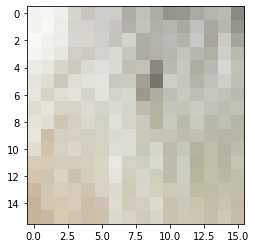

In [ ]:
train_set = []
for parche in target_set:
  parche = cv2.resize(parche,(16,16))
  train_set.append(parche)

train_set = np.array(train_set)
print(train_set.shape)
plt.imshow(train_set[np.random.randint(10000)])
plt.show()


Ahora modifiquemos el modelo de Unet para que se le presenten como entrada parche del tipo $x_{i}$ (tarin_set) y a la salida se obtengan parches del tipo $\hat{y}_i$ que son la estimación de $y_i$ (target_set)

In [ ]:
from tensorflow import keras
from keras.layers import Input, Dense, Activation, Conv2D, Lambda
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
from keras.layers import BatchNormalization, Reshape
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow.python.ops.image_ops_impl import resize_images
from keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [ ]:
train_set = np.array(train_set)
target_set = np.array(target_set)
print(train_set.shape)
print(target_set.shape)

(10000, 16, 16, 3)
(10000, 32, 32, 3)


In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jun  9 01:53:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Toda la arquitectura UNET consiste en el uso repetido de dos convoluciones de $3\times3$, cada una seguida de una activación de ReLU.

Aquí, aquí está el código para construir el bloque de convolución.

In [ ]:
_, num_rows, num_cols, num_channels = train_set.shape
img_dim = (num_rows, num_cols, num_channels,)
filters_per_block = np.array([num_channels, 32, 64, 128])
num_blocks        = len(filters_per_block)   

Los bloques convolucionales Down tienen la estructura:
  - Conv2D 3x3 con activación ReLu con padding para matener la dimensión espacial
  - Conv2D 3x3 con activación ReLu con padding para matener la dimensión espacial
  - Dropoout del 25% (parametro definible)
  - MaxPolling 2x2 que reduce la dimensión espacial

In [ ]:
def conv_block(input, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(rate=0.25)(x)
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(rate=0.25)(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

Bloques convolucionales Up tienen la estructura:


In [ ]:
def decoder_block(input, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def build_unet(input_shape):
    inputs = keras.Input(input_shape)
    X = Lambda(lambda image: resize_images(image, (32, 32)))(inputs)

    s1, p1 = encoder_block(X, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 124)
    s4, p4 = encoder_block(p3, 248)

    b1 = conv_block(p4, 496)

    d1 = decoder_block(b1, s4, 248)
    d2 = decoder_block(d1, s3, 124)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    outputs = layers.Conv2D(3, 3, padding="same", activation="sigmoid")(d4)

    model = keras.Model(inputs, outputs, name="U-Net")
    return model

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 16, 16, 3)]  0                                            
__________________________________________________________________________________________________
tf.compat.v1.image.resize_image (None, 32, 32, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 32, 32, 16)   448         tf.compat.v1.image.resize_images_
__________________________________________________________________________________________________
batch_normalization_108 (BatchN (None, 32, 32, 16)   64          conv2d_114[0][0]                 
______________________________________________________________________________________________

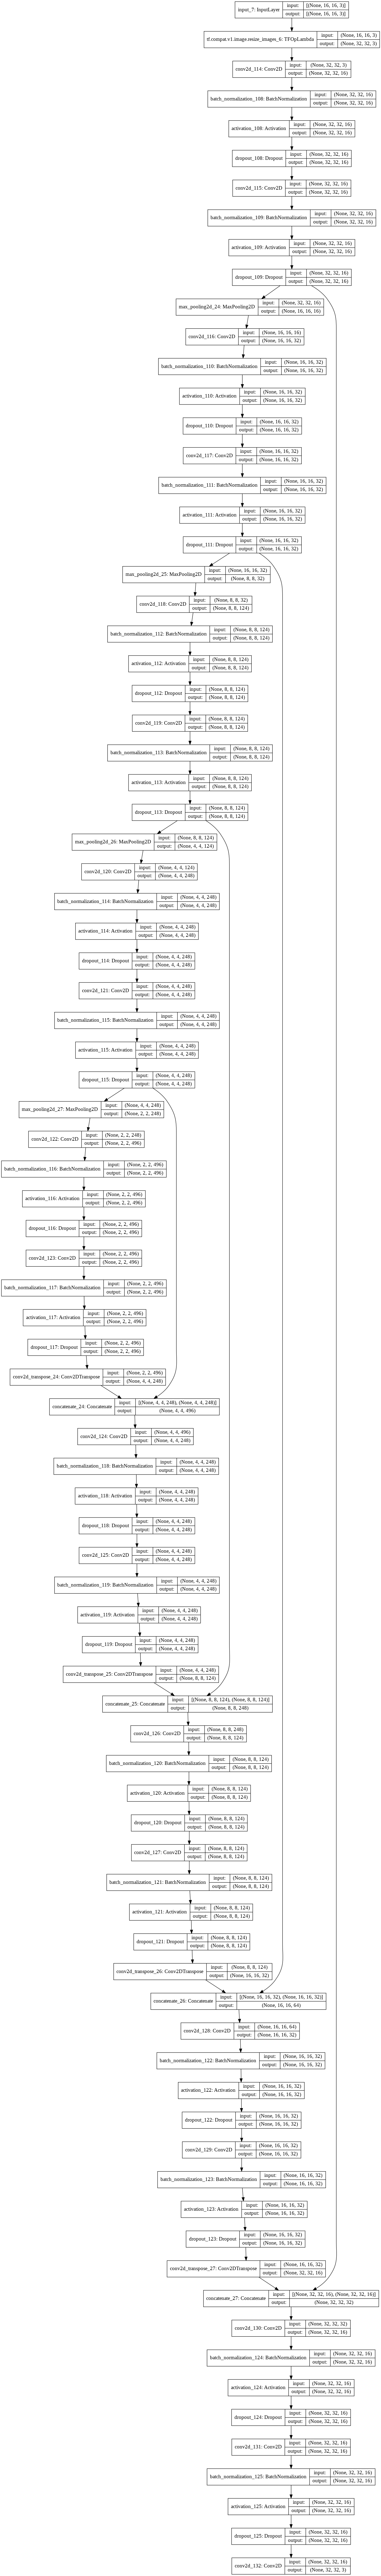

In [ ]:
unet = build_unet(img_dim)
unet.summary()
plot_model(unet, show_shapes=True)

In [ ]:
epochs     = 5        # número de epocas

In [ ]:
unet.compile(optimizer="adam", loss=keras.losses.MAE)

In [ ]:
history = unet.fit(train_set, target_set, epochs = epochs)

Epoch 1/5
313/313 [==============================] - 190s 599ms/step - loss: 0.0779
Epoch 2/5
313/313 [==============================] - 187s 597ms/step - loss: 0.0603
Epoch 3/5
313/313 [==============================] - 187s 597ms/step - loss: 0.0561
Epoch 4/5
313/313 [==============================] - 187s 597ms/step - loss: 0.0533
Epoch 5/5
313/313 [==============================] - 184s 588ms/step - loss: 0.0519


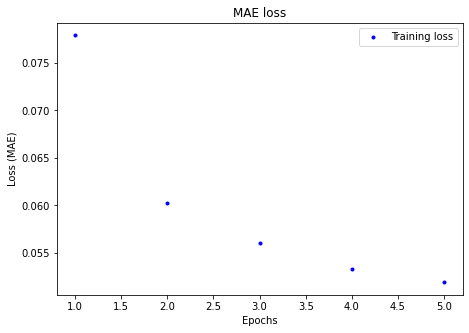

In [ ]:
loss = history.history['loss']


epochs = range(1, len(loss) + 1)
plt.figure(2, figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b.', label='Training loss')
plt.title('MAE loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

Una vez entrenado el modelo, lo guardamos en el Drive y así lo podemos cargar siempre que queramos

In [ ]:
base_dir = '/content/drive/MyDrive/tarea_6'
os.stat(base_dir)
unet.save(base_dir+'/unet.h5')

In [ ]:
from keras.models import load_model

unet = load_model(base_dir+'/unet.h5')

In [ ]:
import time 
tic = time.time()
Y_train_pred = unet.predict(train_set)
print('\n prediction time for the whole dataset image:', time.time()-tic, 'seconds')


 prediction time for the whole dataset image: 33.1139874458313 seconds


(10000, 32, 32, 3)

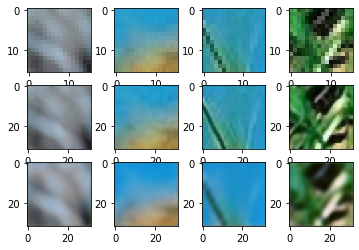

In [ ]:
fig, axs = plt.subplots(3,4)
for i in range(4):
  j = np.random.randint(10000)
  axs[0,i].imshow(train_set[j])
  axs[1,i].imshow(target_set[j])
  axs[2,i].imshow(Y_train_pred[j])
plt.show()
